In [ ]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from datetime import time, datetime
%matplotlib inline
import statsmodels.api as sm
import warnings
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product
from collections import defaultdict
from statsmodels.tsa.ar_model import AutoReg
import warnings
warnings.filterwarnings('ignore')

### Cleaning X data

In [ ]:
df_X = pd.read_csv("/content/salpani_WB__22.5654N_ 87.1554E_dataset_nasa.csv", skiprows=14)

In [ ]:
new_header = df_X.iloc[0]
df_X = df_X[1:]
df_X.columns = new_header

In [ ]:
df_X['date'] = df_X['YEAR'].astype(str) + '-' + df_X['MO'].astype(str) + '-' + df_X['DY'].astype(str)
df_X['date'] = pd.to_datetime(df_X['date'], format='%Y-%m-%d')

In [ ]:
df_X.drop(columns=['YEAR', 'MO', 'DY'], axis=1, inplace=True)

In [ ]:
cols = df_X.columns.tolist()

In [ ]:
cols = cols[-1:] + cols[:-1]

In [ ]:
df_X = df_X[cols]

In [ ]:
df_X = df_X.drop([i for i in range(1, 19)]).reset_index(drop=True)

In [ ]:
df_X['HR'] = pd.to_numeric(df_X['HR'])

In [ ]:
df_X['date'] = pd.to_datetime(df_X['date']) + pd.to_timedelta(df_X['HR'], unit='h')

In [ ]:
df_X.drop(columns=['HR'], axis=1, inplace=True)

we don't have the `ALLSKY_SFC_SW_DWN` and `CLRSKY_SFC_SW_DWN` for the data after 2-12-2022

### Cleaning y data

In [ ]:
df_y = pd.read_excel('/content/HOURLY PV POWER GENERATION SHEET-suvendu.xlsx', skiprows=2)

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.0 MB/s eta 0:00:00


In [ ]:
df_y.rename(columns={'Unnamed: 0': 'date', 'Unnamed: 14': 'EXPORT GENERATION(MWH)', 'Unnamed: 15': 'IMPORT GENERATION(KWH)',
                     'Unnamed: 16': 'NET EXPORT GENRATION(MWH)', 'Unnamed: 17': 'GRID INTERRUPTION(MIN)'}, inplace=True)

In [ ]:
df_y.drop(columns=['Unnamed: 18'], axis=1, inplace=True)

In [ ]:
df_y = df_y.reset_index(drop=True)

In [ ]:
df_y = df_y.drop(range(1, 9), axis=0).reset_index(drop=True)
df_y.drop([0], inplace=True)

In [ ]:
df_y[[time(i) for i in range(0, 6)]] = pd.DataFrame([[0 for _ in range(6)]], index=df_y.index)
df_y[[time(i) for i in range(19, 24)]] = pd.DataFrame([[0 for _ in range(5)]], index=df_y.index)

In [ ]:
cols = df_y.columns.tolist()
for i, j in enumerate(cols):
  print(i, j)

0 date
1 06:00:00
2 07:00:00
3 08:00:00
4 09:00:00
5 10:00:00
6 11:00:00
7 12:00:00
8 13:00:00
9 14:00:00
10 15:00:00
11 16:00:00
12 17:00:00
13 18:00:00
14 EXPORT GENERATION(MWH)
15 IMPORT GENERATION(KWH)
16 NET EXPORT GENRATION(MWH)
17 GRID INTERRUPTION(MIN)
18 00:00:00
19 01:00:00
20 02:00:00
21 03:00:00
22 04:00:00
23 05:00:00
24 19:00:00
25 20:00:00
26 21:00:00
27 22:00:00
28 23:00:00


In [ ]:
cols = cols[:1] + cols[18:24] + cols[1:14] + cols[24:29] + cols[14:18]

In [ ]:
df_y = df_y[cols]

In [ ]:
df_y = df_y.melt(id_vars=["date", "EXPORT GENERATION(MWH)", "IMPORT GENERATION(KWH)", "NET EXPORT GENRATION(MWH)", "GRID INTERRUPTION(MIN)"],
        var_name="Hour",
        value_name="Value")

In [ ]:
df_y = df_y.sort_values(by = ["date", "EXPORT GENERATION(MWH)", "IMPORT GENERATION(KWH)", "NET EXPORT GENRATION(MWH)", "GRID INTERRUPTION(MIN)"])

In [ ]:
df_y = df_y.reset_index(drop=True)

In [ ]:
cols = df_y.columns.tolist()
cols = cols[:1] + cols[-2:] + cols[1:5]
df_y = df_y[cols]

In [ ]:
df_y

,date,Hour,Value,EXPORT GENERATION(MWH),IMPORT GENERATION(KWH),NET EXPORT GENRATION(MWH),GRID INTERRUPTION(MIN)
0,2019-02-10,00:00:00,0,57.40,300.0,57.1,0
1,2019-02-10,01:00:00,0,57.40,300.0,57.1,0
2,2019-02-10,02:00:00,0,57.40,300.0,57.1,0
3,2019-02-10,03:00:00,0,57.40,300.0,57.1,0
4,2019-02-10,04:00:00,0,57.40,300.0,57.1,0
...,...,...,...,...,...,...,...
37723,2023-05-31,19:00:00,0,44.15,250.0,43.9,07 Min(Grid Down From Pirakata SS end. 33 Kv l...
37724,2023-05-31,20:00:00,0,44.15,250.0,43.9,07 Min(Grid Down From Pirakata SS end. 33 Kv l...
37725,2023-05-31,21:00:00,0,44.15,250.0,43.9,07 Min(Grid Down From Pirakata SS end. 33 Kv l...
37726,2023-05-31,22:00:00,0,44.15,250.0,43.9,07 Min(Grid Down From Pirakata SS end. 33 Kv l...


In [ ]:
df_y['date'] = pd.to_datetime(df_y['date'].astype(str) + '-' + df_y['Hour'].astype(str))

In [ ]:
df_y.drop(columns=['Hour'], axis=1, inplace=True)

### Merging the df_X and df_y

In [ ]:
df_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35118 entries, 0 to 35117
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               35118 non-null  datetime64[ns]
 1   T2M                35118 non-null  object        
 2   QV2M               35118 non-null  object        
 3   PRECTOTCORR        35118 non-null  object        
 4   ALLSKY_SFC_SW_DWN  35118 non-null  object        
 5   CLRSKY_SFC_SW_DWN  35118 non-null  object        
 6   PS                 35118 non-null  object        
 7   WS50M              35118 non-null  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 2.1+ MB


In [ ]:
convert_dict = {'T2M': float,
                'QV2M': float,
                'PRECTOTCORR': float,
                'ALLSKY_SFC_SW_DWN': float,
                'CLRSKY_SFC_SW_DWN': float,
                'PS': float,
                'QV2M': float,
                'WS50M': float
                }

df_X = df_X.astype(convert_dict)
df_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35118 entries, 0 to 35117
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               35118 non-null  datetime64[ns]
 1   T2M                35118 non-null  float64       
 2   QV2M               35118 non-null  float64       
 3   PRECTOTCORR        35118 non-null  float64       
 4   ALLSKY_SFC_SW_DWN  35118 non-null  float64       
 5   CLRSKY_SFC_SW_DWN  35118 non-null  float64       
 6   PS                 35118 non-null  float64       
 7   WS50M              35118 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 2.1 MB


In [ ]:
df_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37728 entries, 0 to 37727
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       37728 non-null  datetime64[ns]
 1   Value                      37728 non-null  object        
 2   EXPORT GENERATION(MWH)     37728 non-null  float64       
 3   IMPORT GENERATION(KWH)     37728 non-null  float64       
 4   NET EXPORT GENRATION(MWH)  37728 non-null  float64       
 5   GRID INTERRUPTION(MIN)     34872 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 1.7+ MB


`we have X data from 1-may-2019 to 5-may-2023`

`X -> 1-may-2019 ot 1-dec-2022` others data is unavailable

`we have y data from 9-feb-2019 to 31-may-2023`


In [ ]:
dt_range = np.array(pd.date_range(start='2019-05-01', end='2022-12-01', freq='H')) #31464
dt_range.size

31441

In [ ]:
df_X.index[df_X['date']=='2022-12-02 00:00:00'].tolist()

[31440]

In [ ]:
df_X = df_X[:31440]

In [ ]:
dt_range = pd.date_range(start='2019-05-02', end='2022-12-02', freq='H') #31464
dt_range = dt_range[:-1]
print(dt_range.size)
dt_range

31440


DatetimeIndex(['2019-05-02 00:00:00', '2019-05-02 01:00:00',
               '2019-05-02 02:00:00', '2019-05-02 03:00:00',
               '2019-05-02 04:00:00', '2019-05-02 05:00:00',
               '2019-05-02 06:00:00', '2019-05-02 07:00:00',
               '2019-05-02 08:00:00', '2019-05-02 09:00:00',
               ...
               '2022-12-01 14:00:00', '2022-12-01 15:00:00',
               '2022-12-01 16:00:00', '2022-12-01 17:00:00',
               '2022-12-01 18:00:00', '2022-12-01 19:00:00',
               '2022-12-01 20:00:00', '2022-12-01 21:00:00',
               '2022-12-01 22:00:00', '2022-12-01 23:00:00'],
              dtype='datetime64[ns]', length=31440, freq='H')

In [ ]:
print(df_y.index[df_y['date']=='2019-05-02 00:00:00'].tolist())
print(df_y.index[df_y['date']=='2022-12-01 23:00:00'].tolist()) # 33383

[1944]
[33383]


In [ ]:
df_y.loc[1944]

date                         2019-05-02 00:00:00
Value                                          0
EXPORT GENERATION(MWH)                      36.4
IMPORT GENERATION(KWH)                     250.0
NET EXPORT GENRATION(MWH)                  36.15
GRID INTERRUPTION(MIN)                       362
Name: 1944, dtype: object

In [ ]:
df_y.loc[33383]

date                                                   2022-12-01 23:00:00
Value                                                                    0
EXPORT GENERATION(MWH)                                                39.6
IMPORT GENERATION(KWH)                                               300.0
NET EXPORT GENRATION(MWH)                                             39.3
GRID INTERRUPTION(MIN)       (Generation Shortfall due to low Irradiance.)
Name: 33383, dtype: object

In [ ]:
df_y = df_y[1944:33384].reset_index(drop=True)

In [ ]:
df = pd.merge(df_X, df_y, on = ['date'])

In [ ]:
df

,date,T2M,QV2M,PRECTOTCORR,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN,PS,WS50M,Value,EXPORT GENERATION(MWH),IMPORT GENERATION(KWH),NET EXPORT GENRATION(MWH),GRID INTERRUPTION(MIN)
0,2019-05-02 00:00:00,27.20,18.25,0.0,0.0,0.0,99.41,5.50,0,36.4,250.0,36.15,362
1,2019-05-02 01:00:00,26.74,18.25,0.0,0.0,0.0,99.34,5.27,0,36.4,250.0,36.15,362
2,2019-05-02 02:00:00,26.51,18.31,0.0,0.0,0.0,99.28,5.36,0,36.4,250.0,36.15,362
3,2019-05-02 03:00:00,26.23,18.43,0.0,0.0,0.0,99.24,5.54,0,36.4,250.0,36.15,362
4,2019-05-02 04:00:00,26.09,18.68,0.0,0.0,0.0,99.23,5.58,0,36.4,250.0,36.15,362
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31435,2022-12-01 19:00:00,18.55,10.44,0.0,0.0,0.0,100.20,4.08,0,39.6,300.0,39.30,(Generation Shortfall due to low Irradiance.)
31436,2022-12-01 20:00:00,17.77,10.13,0.0,0.0,0.0,100.25,4.27,0,39.6,300.0,39.30,(Generation Shortfall due to low Irradiance.)
31437,2022-12-01 21:00:00,17.02,9.89,0.0,0.0,0.0,100.26,4.46,0,39.6,300.0,39.30,(Generation Shortfall due to low Irradiance.)
31438,2022-12-01 22:00:00,16.32,9.64,0.0,0.0,0.0,100.26,4.69,0,39.6,300.0,39.30,(Generation Shortfall due to low Irradiance.)


### cleaning Value column

In [ ]:
df['Value'].replace(regex=True, inplace=True, to_replace=r'[^0-9.\-]',value=r'')
val = []
for i in df.Value:
  if not isinstance(i, (float)):
    val.append(0)
  else:
    val.append(i)

df['Value'] = val
df['Value'] = df['Value'].astype(float)
df

,date,T2M,QV2M,PRECTOTCORR,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN,PS,WS50M,Value,EXPORT GENERATION(MWH),IMPORT GENERATION(KWH),NET EXPORT GENRATION(MWH),GRID INTERRUPTION(MIN)
0,2019-05-02 00:00:00,27.20,18.25,0.0,0.0,0.0,99.41,5.50,0.0,36.4,250.0,36.15,362
1,2019-05-02 01:00:00,26.74,18.25,0.0,0.0,0.0,99.34,5.27,0.0,36.4,250.0,36.15,362
2,2019-05-02 02:00:00,26.51,18.31,0.0,0.0,0.0,99.28,5.36,0.0,36.4,250.0,36.15,362
3,2019-05-02 03:00:00,26.23,18.43,0.0,0.0,0.0,99.24,5.54,0.0,36.4,250.0,36.15,362
4,2019-05-02 04:00:00,26.09,18.68,0.0,0.0,0.0,99.23,5.58,0.0,36.4,250.0,36.15,362
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31435,2022-12-01 19:00:00,18.55,10.44,0.0,0.0,0.0,100.20,4.08,0.0,39.6,300.0,39.30,(Generation Shortfall due to low Irradiance.)
31436,2022-12-01 20:00:00,17.77,10.13,0.0,0.0,0.0,100.25,4.27,0.0,39.6,300.0,39.30,(Generation Shortfall due to low Irradiance.)
31437,2022-12-01 21:00:00,17.02,9.89,0.0,0.0,0.0,100.26,4.46,0.0,39.6,300.0,39.30,(Generation Shortfall due to low Irradiance.)
31438,2022-12-01 22:00:00,16.32,9.64,0.0,0.0,0.0,100.26,4.69,0.0,39.6,300.0,39.30,(Generation Shortfall due to low Irradiance.)


In [ ]:
len(val)

31440

In [ ]:
df


,date,T2M,QV2M,PRECTOTCORR,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN,PS,WS50M,Value,EXPORT GENERATION(MWH),IMPORT GENERATION(KWH),NET EXPORT GENRATION(MWH),GRID INTERRUPTION(MIN)
0,2019-05-02 00:00:00,27.20,18.25,0.0,0.0,0.0,99.41,5.50,0.0,36.4,250.0,36.15,362
1,2019-05-02 01:00:00,26.74,18.25,0.0,0.0,0.0,99.34,5.27,0.0,36.4,250.0,36.15,362
2,2019-05-02 02:00:00,26.51,18.31,0.0,0.0,0.0,99.28,5.36,0.0,36.4,250.0,36.15,362
3,2019-05-02 03:00:00,26.23,18.43,0.0,0.0,0.0,99.24,5.54,0.0,36.4,250.0,36.15,362
4,2019-05-02 04:00:00,26.09,18.68,0.0,0.0,0.0,99.23,5.58,0.0,36.4,250.0,36.15,362
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31435,2022-12-01 19:00:00,18.55,10.44,0.0,0.0,0.0,100.20,4.08,0.0,39.6,300.0,39.30,(Generation Shortfall due to low Irradiance.)
31436,2022-12-01 20:00:00,17.77,10.13,0.0,0.0,0.0,100.25,4.27,0.0,39.6,300.0,39.30,(Generation Shortfall due to low Irradiance.)
31437,2022-12-01 21:00:00,17.02,9.89,0.0,0.0,0.0,100.26,4.46,0.0,39.6,300.0,39.30,(Generation Shortfall due to low Irradiance.)
31438,2022-12-01 22:00:00,16.32,9.64,0.0,0.0,0.0,100.26,4.69,0.0,39.6,300.0,39.30,(Generation Shortfall due to low Irradiance.)


In [ ]:
df.rename(columns={'Value':'Power'},inplace=True)

In [ ]:
df

,date,T2M,QV2M,PRECTOTCORR,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN,PS,WS50M,Power,EXPORT GENERATION(MWH),IMPORT GENERATION(KWH),NET EXPORT GENRATION(MWH),GRID INTERRUPTION(MIN)
0,2019-05-02 00:00:00,27.20,18.25,0.0,0.0,0.0,99.41,5.50,0.0,36.4,250.0,36.15,362
1,2019-05-02 01:00:00,26.74,18.25,0.0,0.0,0.0,99.34,5.27,0.0,36.4,250.0,36.15,362
2,2019-05-02 02:00:00,26.51,18.31,0.0,0.0,0.0,99.28,5.36,0.0,36.4,250.0,36.15,362
3,2019-05-02 03:00:00,26.23,18.43,0.0,0.0,0.0,99.24,5.54,0.0,36.4,250.0,36.15,362
4,2019-05-02 04:00:00,26.09,18.68,0.0,0.0,0.0,99.23,5.58,0.0,36.4,250.0,36.15,362
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31435,2022-12-01 19:00:00,18.55,10.44,0.0,0.0,0.0,100.20,4.08,0.0,39.6,300.0,39.30,(Generation Shortfall due to low Irradiance.)
31436,2022-12-01 20:00:00,17.77,10.13,0.0,0.0,0.0,100.25,4.27,0.0,39.6,300.0,39.30,(Generation Shortfall due to low Irradiance.)
31437,2022-12-01 21:00:00,17.02,9.89,0.0,0.0,0.0,100.26,4.46,0.0,39.6,300.0,39.30,(Generation Shortfall due to low Irradiance.)
31438,2022-12-01 22:00:00,16.32,9.64,0.0,0.0,0.0,100.26,4.69,0.0,39.6,300.0,39.30,(Generation Shortfall due to low Irradiance.)


In [ ]:
df.drop(columns={'EXPORT GENERATION(MWH)'},inplace=True)

In [ ]:
df

,date,T2M,QV2M,PRECTOTCORR,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN,PS,WS50M,Power,IMPORT GENERATION(KWH),NET EXPORT GENRATION(MWH),GRID INTERRUPTION(MIN)
0,2019-05-02 00:00:00,27.20,18.25,0.0,0.0,0.0,99.41,5.50,0.0,250.0,36.15,362
1,2019-05-02 01:00:00,26.74,18.25,0.0,0.0,0.0,99.34,5.27,0.0,250.0,36.15,362
2,2019-05-02 02:00:00,26.51,18.31,0.0,0.0,0.0,99.28,5.36,0.0,250.0,36.15,362
3,2019-05-02 03:00:00,26.23,18.43,0.0,0.0,0.0,99.24,5.54,0.0,250.0,36.15,362
4,2019-05-02 04:00:00,26.09,18.68,0.0,0.0,0.0,99.23,5.58,0.0,250.0,36.15,362
...,...,...,...,...,...,...,...,...,...,...,...,...
31435,2022-12-01 19:00:00,18.55,10.44,0.0,0.0,0.0,100.20,4.08,0.0,300.0,39.30,(Generation Shortfall due to low Irradiance.)
31436,2022-12-01 20:00:00,17.77,10.13,0.0,0.0,0.0,100.25,4.27,0.0,300.0,39.30,(Generation Shortfall due to low Irradiance.)
31437,2022-12-01 21:00:00,17.02,9.89,0.0,0.0,0.0,100.26,4.46,0.0,300.0,39.30,(Generation Shortfall due to low Irradiance.)
31438,2022-12-01 22:00:00,16.32,9.64,0.0,0.0,0.0,100.26,4.69,0.0,300.0,39.30,(Generation Shortfall due to low Irradiance.)


In [ ]:
df.drop(columns={'IMPORT GENERATION(KWH)','NET EXPORT GENRATION(MWH)','GRID INTERRUPTION(MIN)'},inplace=True)# this columns are not needed for our analysis

In [ ]:
df

,date,T2M,QV2M,PRECTOTCORR,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN,PS,WS50M,Power
0,2019-05-02 00:00:00,27.20,18.25,0.0,0.0,0.0,99.41,5.50,0.0
1,2019-05-02 01:00:00,26.74,18.25,0.0,0.0,0.0,99.34,5.27,0.0
2,2019-05-02 02:00:00,26.51,18.31,0.0,0.0,0.0,99.28,5.36,0.0
3,2019-05-02 03:00:00,26.23,18.43,0.0,0.0,0.0,99.24,5.54,0.0
4,2019-05-02 04:00:00,26.09,18.68,0.0,0.0,0.0,99.23,5.58,0.0
...,...,...,...,...,...,...,...,...,...
31435,2022-12-01 19:00:00,18.55,10.44,0.0,0.0,0.0,100.20,4.08,0.0
31436,2022-12-01 20:00:00,17.77,10.13,0.0,0.0,0.0,100.25,4.27,0.0
31437,2022-12-01 21:00:00,17.02,9.89,0.0,0.0,0.0,100.26,4.46,0.0
31438,2022-12-01 22:00:00,16.32,9.64,0.0,0.0,0.0,100.26,4.69,0.0


In [ ]:
df.rename(columns={'T2M':'temp','QV2M':'humidity','PRECTOTCORR':'precipitation','ALLSKY_SFC_SW_DWN':'rad_all_sky','CLRSKY_SFC_SW_DWN':'clearsky_rad','PS':'Pressure',
                'WS50M':'wind speed'},inplace=True)#renaming the columns with identifiable names for better understanding

In [ ]:
df

,date,temp,humidity,precipitation,rad_all_sky,clearsky_rad,Pressure,wind speed,Power
0,2019-05-02 00:00:00,27.20,18.25,0.0,0.0,0.0,99.41,5.50,0.0
1,2019-05-02 01:00:00,26.74,18.25,0.0,0.0,0.0,99.34,5.27,0.0
2,2019-05-02 02:00:00,26.51,18.31,0.0,0.0,0.0,99.28,5.36,0.0
3,2019-05-02 03:00:00,26.23,18.43,0.0,0.0,0.0,99.24,5.54,0.0
4,2019-05-02 04:00:00,26.09,18.68,0.0,0.0,0.0,99.23,5.58,0.0
...,...,...,...,...,...,...,...,...,...
31435,2022-12-01 19:00:00,18.55,10.44,0.0,0.0,0.0,100.20,4.08,0.0
31436,2022-12-01 20:00:00,17.77,10.13,0.0,0.0,0.0,100.25,4.27,0.0
31437,2022-12-01 21:00:00,17.02,9.89,0.0,0.0,0.0,100.26,4.46,0.0
31438,2022-12-01 22:00:00,16.32,9.64,0.0,0.0,0.0,100.26,4.69,0.0


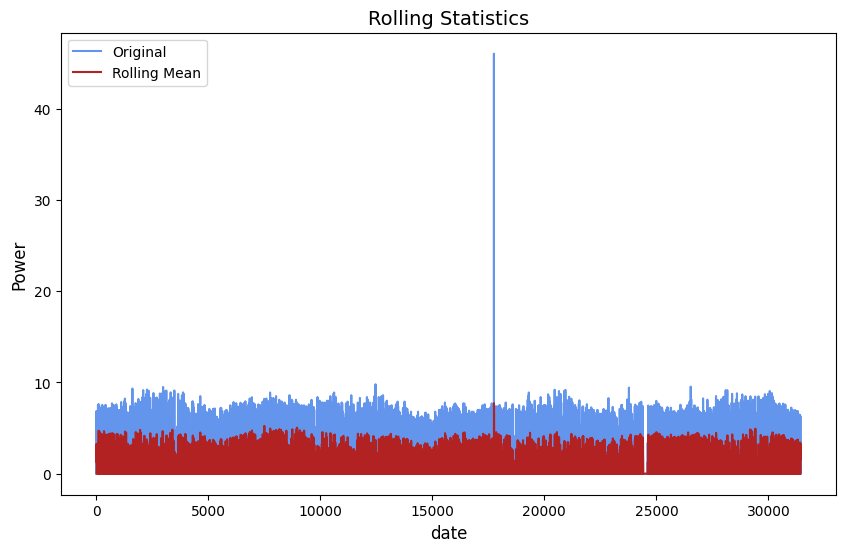

In [ ]:
#we can visualise the data now

rolling_mean = df.Power.rolling(window=12).mean()

rolling_std = df.Power.rolling(window=12).std()

plt.figure(figsize = (10,6))
plt.plot(df.Power, color='cornflowerblue', label='Original')

plt.plot(rolling_mean, color='firebrick', label='Rolling Mean')


plt.xlabel('date', size = 12)
plt.ylabel('Power', size  = 12)

plt.legend(loc = 'upper left')
plt.title('Rolling Statistics', size = 14)
plt.show()





In [ ]:
df.rad_all_sky = df.rad_all_sky.mask((df.rad_all_sky.lt(0)).ffill().fillna(0)) #some of the values in the rad_all_sky
#are negative values which are un realistic and the same has been reploaced with 0


In [ ]:
df.clearsky_rad = df.clearsky_rad.mask((df.clearsky_rad.lt(0)).ffill().fillna(0))

In [ ]:

df

,date,temp,humidity,precipitation,rad_all_sky,clearsky_rad,Pressure,wind speed,Power
0,2019-05-02 00:00:00,27.20,18.25,0.0,0.0,0.0,99.41,5.50,0.0
1,2019-05-02 01:00:00,26.74,18.25,0.0,0.0,0.0,99.34,5.27,0.0
2,2019-05-02 02:00:00,26.51,18.31,0.0,0.0,0.0,99.28,5.36,0.0
3,2019-05-02 03:00:00,26.23,18.43,0.0,0.0,0.0,99.24,5.54,0.0
4,2019-05-02 04:00:00,26.09,18.68,0.0,0.0,0.0,99.23,5.58,0.0
...,...,...,...,...,...,...,...,...,...
31435,2022-12-01 19:00:00,18.55,10.44,0.0,0.0,0.0,100.20,4.08,0.0
31436,2022-12-01 20:00:00,17.77,10.13,0.0,0.0,0.0,100.25,4.27,0.0
31437,2022-12-01 21:00:00,17.02,9.89,0.0,0.0,0.0,100.26,4.46,0.0
31438,2022-12-01 22:00:00,16.32,9.64,0.0,0.0,0.0,100.26,4.69,0.0


<Axes: xlabel='date'>

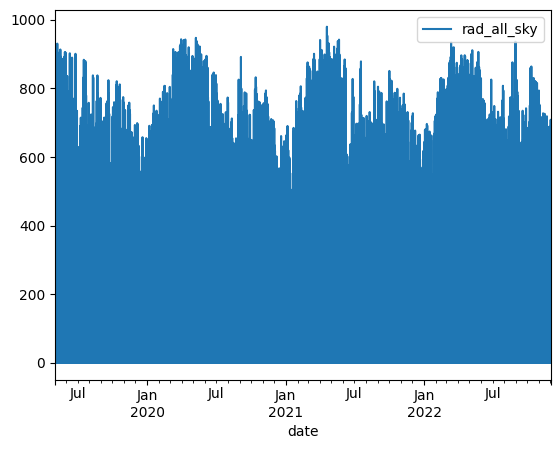

In [ ]:
df.plot(x='date',y='rad_all_sky',kind='line',fig=(8,12))

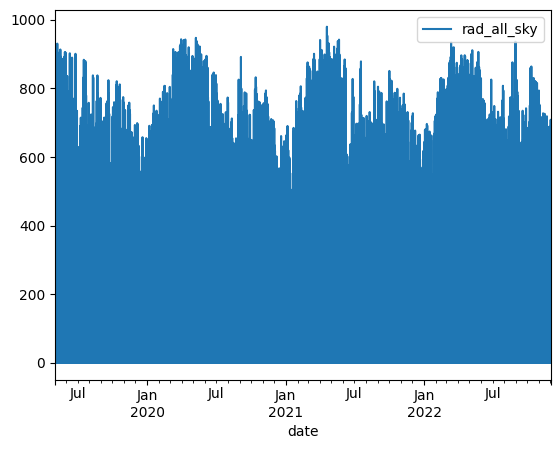

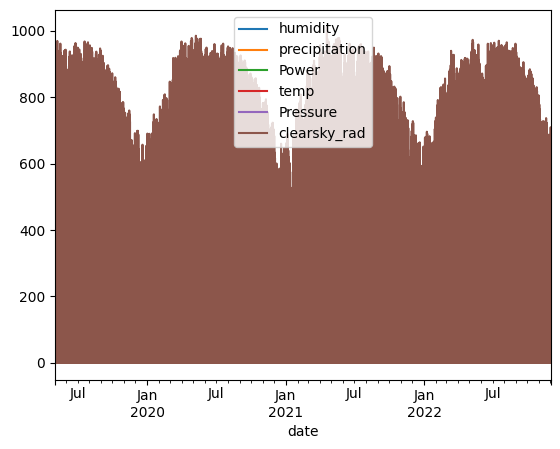

In [ ]:
df.plot(x='date',y='rad_all_sky',kind='line',fig=(8,12))

df.plot(x = 'date', y = ['humidity','precipitation','Power','temp','Pressure','clearsky_rad'], kind='line',fig=(12,25))
plt.title
plt.xlabel
plt.ylabel
plt.show()


In [ ]:
plt.title


<function matplotlib.pyplot.title(label, fontdict=None, loc=None, pad=None, *, y=None, **kwargs)>

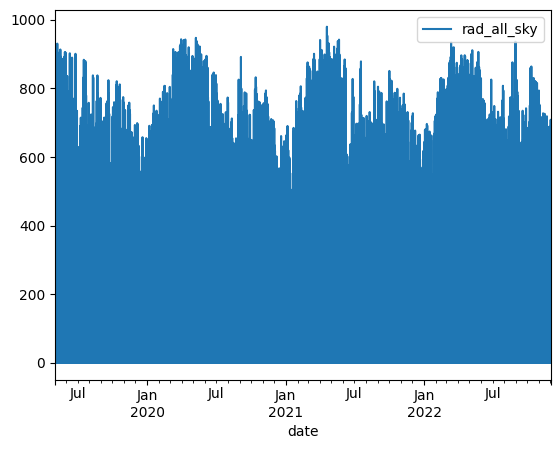

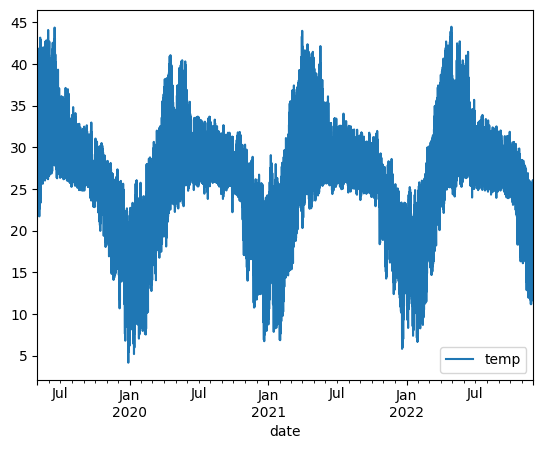

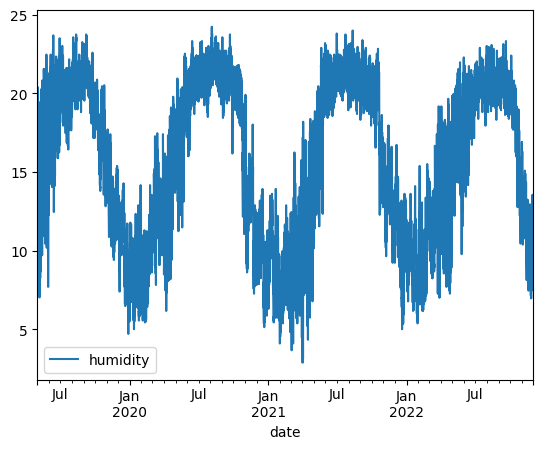

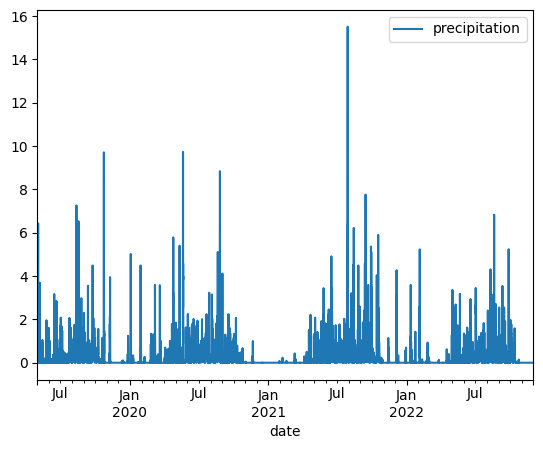

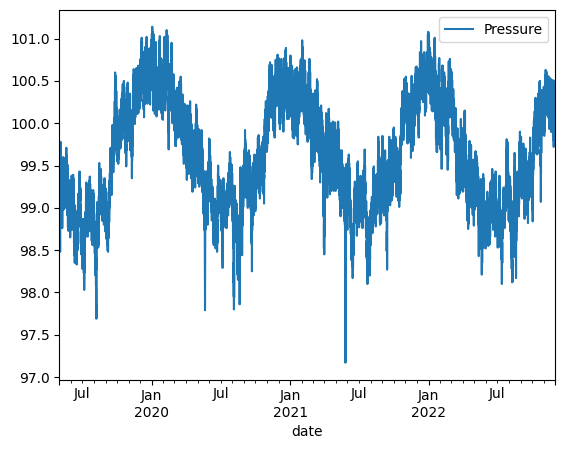

In [ ]:
df.plot(x='date',y='rad_all_sky',kind='line',fig=(8,12))

df.plot(x = 'date', y = ['temp'], kind='line',fig=(12,25))
df.plot(x = 'date', y = ['humidity'], kind='line',fig=(12,25))
df.plot(x = 'date', y = ['precipitation'], kind='line',fig=(12,25))
df.plot(x = 'date', y = ['Pressure'], kind='line',fig=(12,25))

plt.title
plt.xlabel
plt.ylabel
plt.show()


In [ ]:
#we need to clean the clearsky_rad parameters
df.clearsky_rad = df.clearsky_rad.mask((df.clearsky_rad.lt(0)).ffill().fillna(0))
df.rad_all_sky = df.rad_all_sky.mask((df.rad_all_sky.lt(0)).ffill().fillna(0))
df.dropna(axis=0)

,date,temp,humidity,precipitation,rad_all_sky,clearsky_rad,Pressure,wind speed,Power
0,2019-05-02 00:00:00,27.20,18.25,0.0,0.0,0.0,99.41,5.50,0.0
1,2019-05-02 01:00:00,26.74,18.25,0.0,0.0,0.0,99.34,5.27,0.0
2,2019-05-02 02:00:00,26.51,18.31,0.0,0.0,0.0,99.28,5.36,0.0
3,2019-05-02 03:00:00,26.23,18.43,0.0,0.0,0.0,99.24,5.54,0.0
4,2019-05-02 04:00:00,26.09,18.68,0.0,0.0,0.0,99.23,5.58,0.0
...,...,...,...,...,...,...,...,...,...
31435,2022-12-01 19:00:00,18.55,10.44,0.0,0.0,0.0,100.20,4.08,0.0
31436,2022-12-01 20:00:00,17.77,10.13,0.0,0.0,0.0,100.25,4.27,0.0
31437,2022-12-01 21:00:00,17.02,9.89,0.0,0.0,0.0,100.26,4.46,0.0
31438,2022-12-01 22:00:00,16.32,9.64,0.0,0.0,0.0,100.26,4.69,0.0


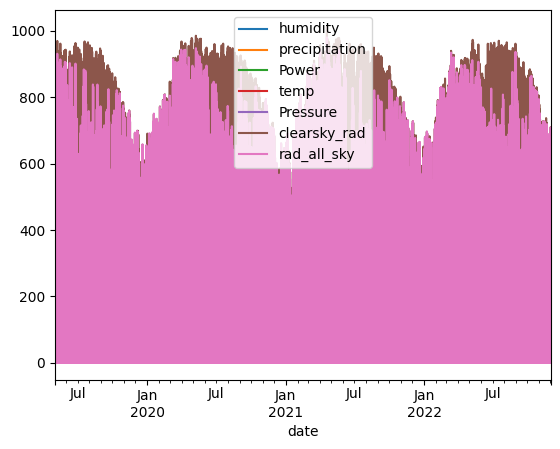

In [ ]:
df.plot(x = 'date', y = ['humidity','precipitation','Power','temp','Pressure','clearsky_rad','rad_all_sky'], kind='line',fig=(12,25))
plt.title
plt.xlabel
plt.ylabel
plt.show()

In [ ]:
## we can find that there is no negative values against this parameters which  , if present would be unrealistic.


In [ ]:
# to save the dataframe as excel file:1
df.to_excel('cleaned_data_for_solar_forecasting.xlsx')

In [ ]:
import statsmodels.api as sm

In [ ]:
from statsmodels.tsa.ar_model import AutoReg

### we need to check the stationality of the time series and here the test resorted is the Augmented Dicky Fuller test

In [ ]:
df

,date,temp,humidity,precipitation,rad_all_sky,clearsky_rad,Pressure,wind speed,Power
0,2019-05-02 00:00:00,27.20,18.25,0.0,0.0,0.0,99.41,5.50,0.0
1,2019-05-02 01:00:00,26.74,18.25,0.0,0.0,0.0,99.34,5.27,0.0
2,2019-05-02 02:00:00,26.51,18.31,0.0,0.0,0.0,99.28,5.36,0.0
3,2019-05-02 03:00:00,26.23,18.43,0.0,0.0,0.0,99.24,5.54,0.0
4,2019-05-02 04:00:00,26.09,18.68,0.0,0.0,0.0,99.23,5.58,0.0
...,...,...,...,...,...,...,...,...,...
31435,2022-12-01 19:00:00,18.55,10.44,0.0,0.0,0.0,100.20,4.08,0.0
31436,2022-12-01 20:00:00,17.77,10.13,0.0,0.0,0.0,100.25,4.27,0.0
31437,2022-12-01 21:00:00,17.02,9.89,0.0,0.0,0.0,100.26,4.46,0.0
31438,2022-12-01 22:00:00,16.32,9.64,0.0,0.0,0.0,100.26,4.69,0.0


In [ ]:
np.any(~np.isfinite(df.rad_all_sky),axis=0)# checked any of the values are na and the result is that some of the values are na


True

In [ ]:

df=df.fillna(0)# we are filling na with 0 values


In [ ]:
np.any(~np.isfinite(df.rad_all_sky),axis=0)
np.any(~np.isfinite(df.clearsky_rad),axis=0)# no na is there

False

In [ ]:
df.isnull().sum() # reconfirming that there is no na

date             0
temp             0
humidity         0
precipitation    0
rad_all_sky      0
clearsky_rad     0
Pressure         0
wind speed       0
Power            0
dtype: int64

In [ ]:
df.set_index('date',inplace=True)

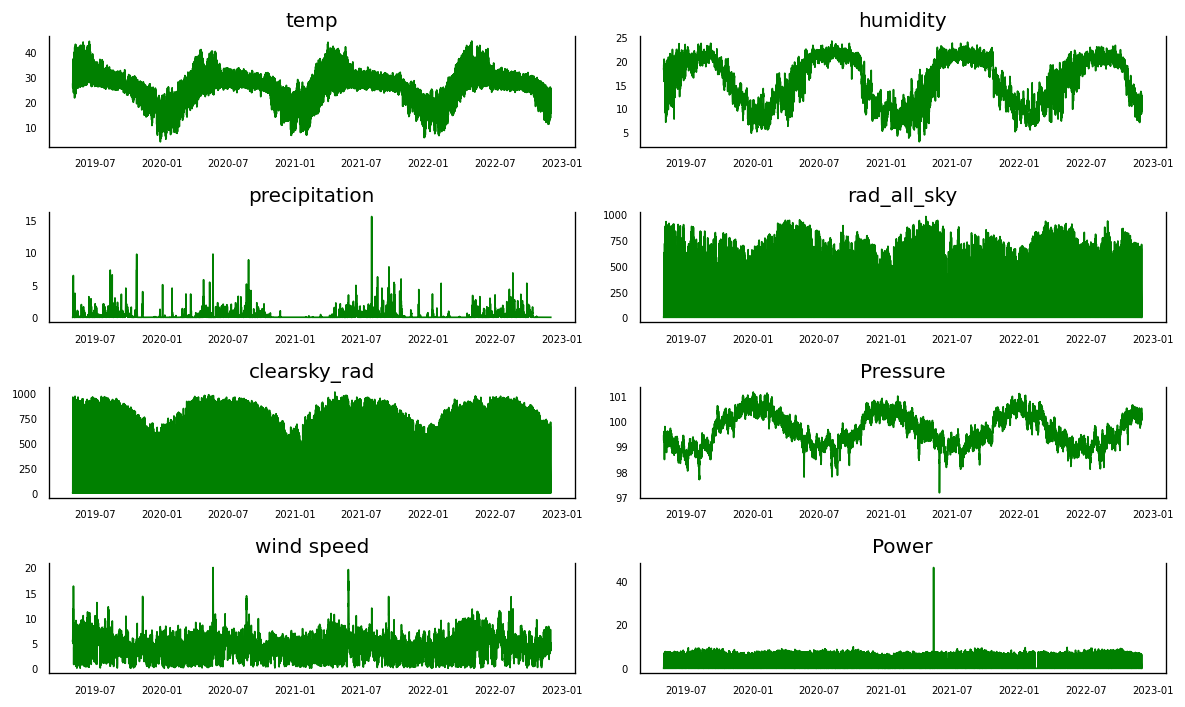

In [ ]:


fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):

    data = df[df.columns[i]]
    ax.plot(data, color='green', linewidth=1)

    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();


In [ ]:
df

,temp,humidity,precipitation,rad_all_sky,clearsky_rad,Pressure,wind speed,Power
date,,,,,,,,
2019-05-02 00:00:00,27.20,18.25,0.0,0.0,0.0,99.41,5.50,0.0
2019-05-02 01:00:00,26.74,18.25,0.0,0.0,0.0,99.34,5.27,0.0
2019-05-02 02:00:00,26.51,18.31,0.0,0.0,0.0,99.28,5.36,0.0
2019-05-02 03:00:00,26.23,18.43,0.0,0.0,0.0,99.24,5.54,0.0
2019-05-02 04:00:00,26.09,18.68,0.0,0.0,0.0,99.23,5.58,0.0
...,...,...,...,...,...,...,...,...
2022-12-01 19:00:00,18.55,10.44,0.0,0.0,0.0,100.20,4.08,0.0
2022-12-01 20:00:00,17.77,10.13,0.0,0.0,0.0,100.25,4.27,0.0
2022-12-01 21:00:00,17.02,9.89,0.0,0.0,0.0,100.26,4.46,0.0


In [ ]:
ad_fuller_result_1 = adfuller(df['temp'])
print('realtemp')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(df['humidity'])
print('realhumidity')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

print('\n---------------------\n')

ad_fuller_result_3 = adfuller(df['precipitation'])
print('realprecipitation')
print(f'ADF Statistic: {ad_fuller_result_3[0]}')
print(f'p-value: {ad_fuller_result_3[1]}')

print('\n---------------------\n')

ad_fuller_result_4 = adfuller(df['rad_all_sky'])
print('realrad_all_sky')
print(f'ADF Statistic: {ad_fuller_result_4[0]}')
print(f'p-value: {ad_fuller_result_4[1]}')

print('\n---------------------\n')

ad_fuller_result_5 = adfuller(df['clearsky_rad'])
print('realclearsky_rad')
print(f'ADF Statistic: {ad_fuller_result_5[0]}')
print(f'p-value: {ad_fuller_result_5[1]}')

print('\n---------------------\n')


ad_fuller_result_6 = adfuller(df['Pressure'])
print('realPressure')
print(f'ADF Statistic: {ad_fuller_result_6[0]}')
print(f'p-value: {ad_fuller_result_6[1]}')

print('\n---------------------\n')

ad_fuller_result_7 = adfuller(df['wind speed'])
print('realwind speed')
print(f'ADF Statistic: {ad_fuller_result_7[0]}')
print(f'p-value: {ad_fuller_result_7[1]}')

print('\n---------------------\n')

ad_fuller_result_8 = adfuller(df['Power'])
print('realPower')
print(f'ADF Statistic: {ad_fuller_result_8[0]}')
print(f'p-value: {ad_fuller_result_8[1]}')






realtemp
ADF Statistic: -3.338748359666645
p-value: 0.013232807787961065

---------------------

realhumidity
ADF Statistic: -4.0871852708175345
p-value: 0.0010168557811829312

---------------------

realprecipitation
ADF Statistic: -22.144248983640082
p-value: 0.0

---------------------

realrad_all_sky
ADF Statistic: -13.05861630660579
p-value: 2.069697042980445e-24

---------------------

realclearsky_rad
ADF Statistic: -4.542219089828703
p-value: 0.00016483887926837528

---------------------

realPressure
ADF Statistic: -4.9612553627217775
p-value: 2.6464053028014006e-05

---------------------

realwind speed
ADF Statistic: -16.17352590471825
p-value: 4.3398539280325336e-29

---------------------

realPower
ADF Statistic: -16.145438664082544
p-value: 4.6285406039385736e-29


In [ ]:
#since the features exhibit repitative trends we are sure that the time series is not stationary and we need to make it stationary by performing difference operaton


ad_fuller_result_1 = adfuller(df['temp'].diff()[1:])

print('realtemp')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(df['humidity'].diff()[1:])

print('realhumidity')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

print('\n---------------------\n')

ad_fuller_result_3 = adfuller(df['precipitation'].diff()[1:])
print('realprecipitation')
print(f'ADF Statistic: {ad_fuller_result_3[0]}')
print(f'p-value: {ad_fuller_result_3[1]}')

print('\n---------------------\n')

ad_fuller_result_3 = adfuller(df['precipitation'].diff()[1:])
print('realprecipitation')
print(f'ADF Statistic: {ad_fuller_result_3[0]}')
print(f'p-value: {ad_fuller_result_3[1]}')

print('\n---------------------\n')


ad_fuller_result_4 = adfuller(df['rad_all_sky'].diff()[1:])
print('realrad_all_sky')
print(f'ADF Statistic: {ad_fuller_result_4[0]}')
print(f'p-value: {ad_fuller_result_4[1]}')

print('\n---------------------\n')

ad_fuller_result_5 = adfuller(df['clearsky_rad'].diff()[1:])
print('realclearsky_rad')
print(f'ADF Statistic: {ad_fuller_result_5[0]}')
print(f'p-value: {ad_fuller_result_5[1]}')

print('\n---------------------\n')

ad_fuller_result_6 = adfuller(df['Pressure'].diff()[1:])
print('realPressure')
print(f'ADF Statistic: {ad_fuller_result_6[0]}')
print(f'p-value: {ad_fuller_result_6[1]}')


print('\n---------------------\n')


ad_fuller_result_7 = adfuller(df['wind speed'].diff()[1:])
print('realwind speed')
print(f'ADF Statistic: {ad_fuller_result_7[0]}')
print(f'p-value: {ad_fuller_result_7[1]}')

print('\n---------------------\n')


ad_fuller_result_8 = adfuller(df['Power'].diff()[1:])
print('realPower')
print(f'ADF Statistic: {ad_fuller_result_8[0]}')
print(f'p-value: {ad_fuller_result_8[1]}')

realtemp
ADF Statistic: -27.255749382022714
p-value: 0.0

---------------------

realhumidity
ADF Statistic: -27.26416461306298
p-value: 0.0

---------------------

realprecipitation
ADF Statistic: -34.68497663736647
p-value: 0.0

---------------------

realprecipitation
ADF Statistic: -34.68497663736647
p-value: 0.0

---------------------

realrad_all_sky
ADF Statistic: -36.8109030573862
p-value: 0.0

---------------------

realclearsky_rad
ADF Statistic: -34.19068053153533
p-value: 0.0

---------------------

realPressure
ADF Statistic: -26.35098678697217
p-value: 0.0

---------------------

realwind speed
ADF Statistic: -31.784396913667386
p-value: 0.0

---------------------

realPower
ADF Statistic: -38.49977339588113
p-value: 0.0


In [ ]:
#Granger Causality Test gor conducting correlation test. Now we are going to conduct correlation test between the parameters temp and power

In [ ]:

print('\ Power causes temp?\n')
print('------------------')
granger_1 = grangercausalitytests(df[['temp', 'Power']], 4)

print('\Temp causes Power?\n')
print('------------------')
granger_2 = grangercausalitytests(df[['Power', 'temp']], 4)


print('\ humidity causes Power?\n')
print('------------------')
granger_1 = grangercausalitytests(df[['Power', 'humidity']], 4)


print('\rad_all_sky causes Power?\n')
print('------------------')
granger_1 = grangercausalitytests(df[['Power', 'rad_all_sky']], 4)


print('\clearsky_rad causes Power?\n')
print('------------------')
granger_1 = grangercausalitytests(df[['Power', 'clearsky_rad']], 4)

print('\wind speed causes power?\n')
print('------------------')
granger_1 = grangercausalitytests(df[['Power', 'wind speed']], 4)










\ Power causes temp?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5241.9528, p=0.0000  , df_denom=31436, df_num=1
ssr based chi2 test:   chi2=5242.4530, p=0.0000  , df=1
likelihood ratio test: chi2=4848.5886, p=0.0000  , df=1
parameter F test:         F=5241.9528, p=0.0000  , df_denom=31436, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1701.3119, p=0.0000  , df_denom=31433, df_num=2
ssr based chi2 test:   chi2=3403.1650, p=0.0000  , df=2
likelihood ratio test: chi2=3231.2680, p=0.0000  , df=2
parameter F test:         F=1701.3119, p=0.0000  , df_denom=31433, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=734.6754, p=0.0000  , df_denom=31430, df_num=3
ssr based chi2 test:   chi2=2204.5170, p=0.0000  , df=3
likelihood ratio test: chi2=2130.6548, p=0.0000  , df=3
parameter F test:         F=734.6754, p=0.0000  , df_denom=31430, df_num=3

Granger Causality
number of la

In [ ]:
#correlation of the various parameters

In [ ]:
display(df.corr(method='pearson'))

,temp,humidity,precipitation,rad_all_sky,clearsky_rad,Pressure,wind speed,Power
temp,1.000000,0.506259,0.112123,0.514829,0.537697,-0.653360,-0.023702,0.423734
humidity,0.506259,1.000000,0.305271,-0.075683,0.036071,-0.758833,0.234414,-0.110733
precipitation,0.112123,0.305271,1.000000,-0.040115,0.074610,-0.290177,0.234636,-0.058324
rad_all_sky,0.514829,-0.075683,-0.040115,1.000000,0.943507,0.013814,-0.261001,0.914932
clearsky_rad,0.537697,0.036071,0.074610,0.943507,1.000000,-0.085037,-0.181904,0.847605
Pressure,-0.653360,-0.758833,-0.290177,0.013814,-0.085037,1.000000,-0.329536,0.074521
wind speed,-0.023702,0.234414,0.234636,-0.261001,-0.181904,-0.329536,1.000000,-0.264260
Power,0.423734,-0.110733,-0.058324,0.914932,0.847605,0.074521,-0.264260,1.000000


In [ ]:
import seaborn as sns

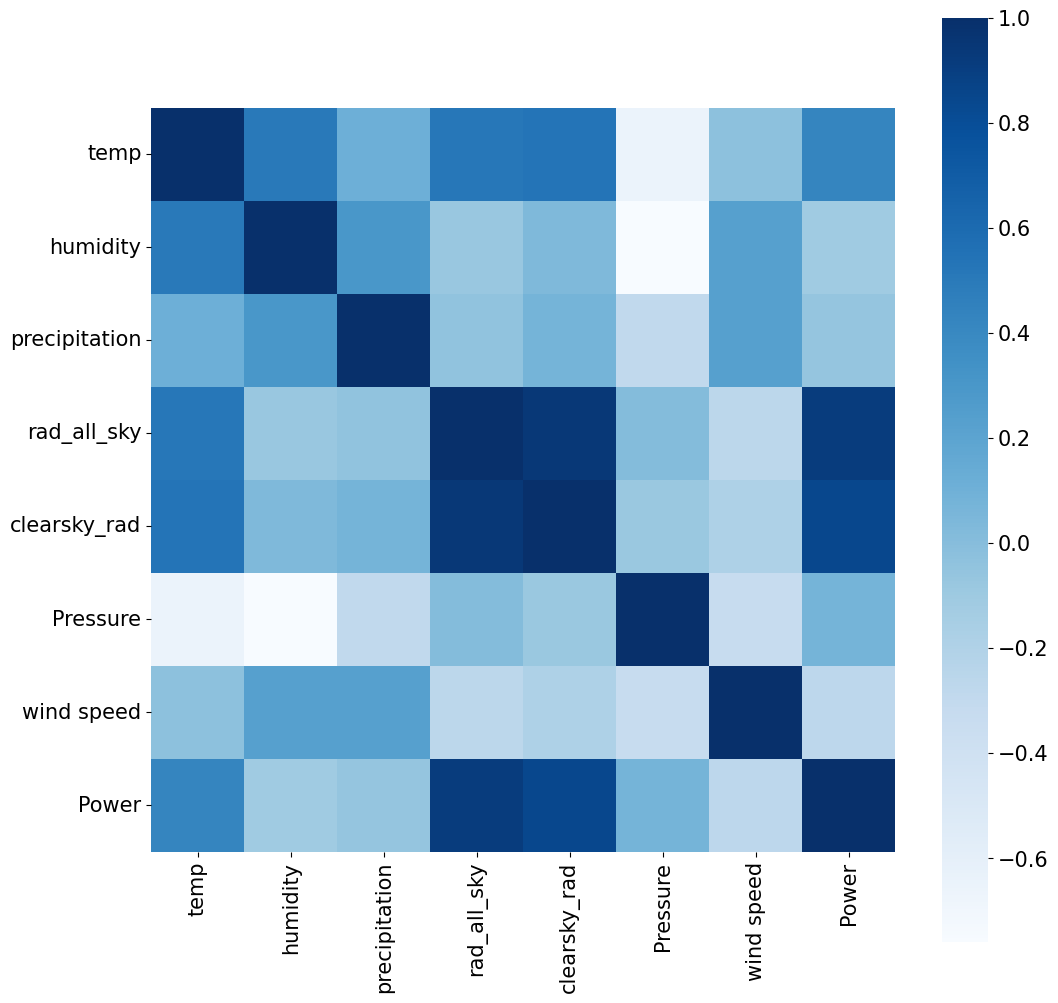

In [ ]:
#correlation heat map
plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams["font.size"] = 15

sns.heatmap(df.corr(), square=True, cmap='Blues')
plt.show()


In [ ]:
df=df.reset_index()

In [ ]:
df

,date,temp,humidity,precipitation,rad_all_sky,clearsky_rad,Pressure,wind speed,Power
0,2019-05-02 00:00:00,27.20,18.25,0.0,0.0,0.0,99.41,5.50,0.0
1,2019-05-02 01:00:00,26.74,18.25,0.0,0.0,0.0,99.34,5.27,0.0
2,2019-05-02 02:00:00,26.51,18.31,0.0,0.0,0.0,99.28,5.36,0.0
3,2019-05-02 03:00:00,26.23,18.43,0.0,0.0,0.0,99.24,5.54,0.0
4,2019-05-02 04:00:00,26.09,18.68,0.0,0.0,0.0,99.23,5.58,0.0
...,...,...,...,...,...,...,...,...,...
31435,2022-12-01 19:00:00,18.55,10.44,0.0,0.0,0.0,100.20,4.08,0.0
31436,2022-12-01 20:00:00,17.77,10.13,0.0,0.0,0.0,100.25,4.27,0.0
31437,2022-12-01 21:00:00,17.02,9.89,0.0,0.0,0.0,100.26,4.46,0.0
31438,2022-12-01 22:00:00,16.32,9.64,0.0,0.0,0.0,100.26,4.69,0.0


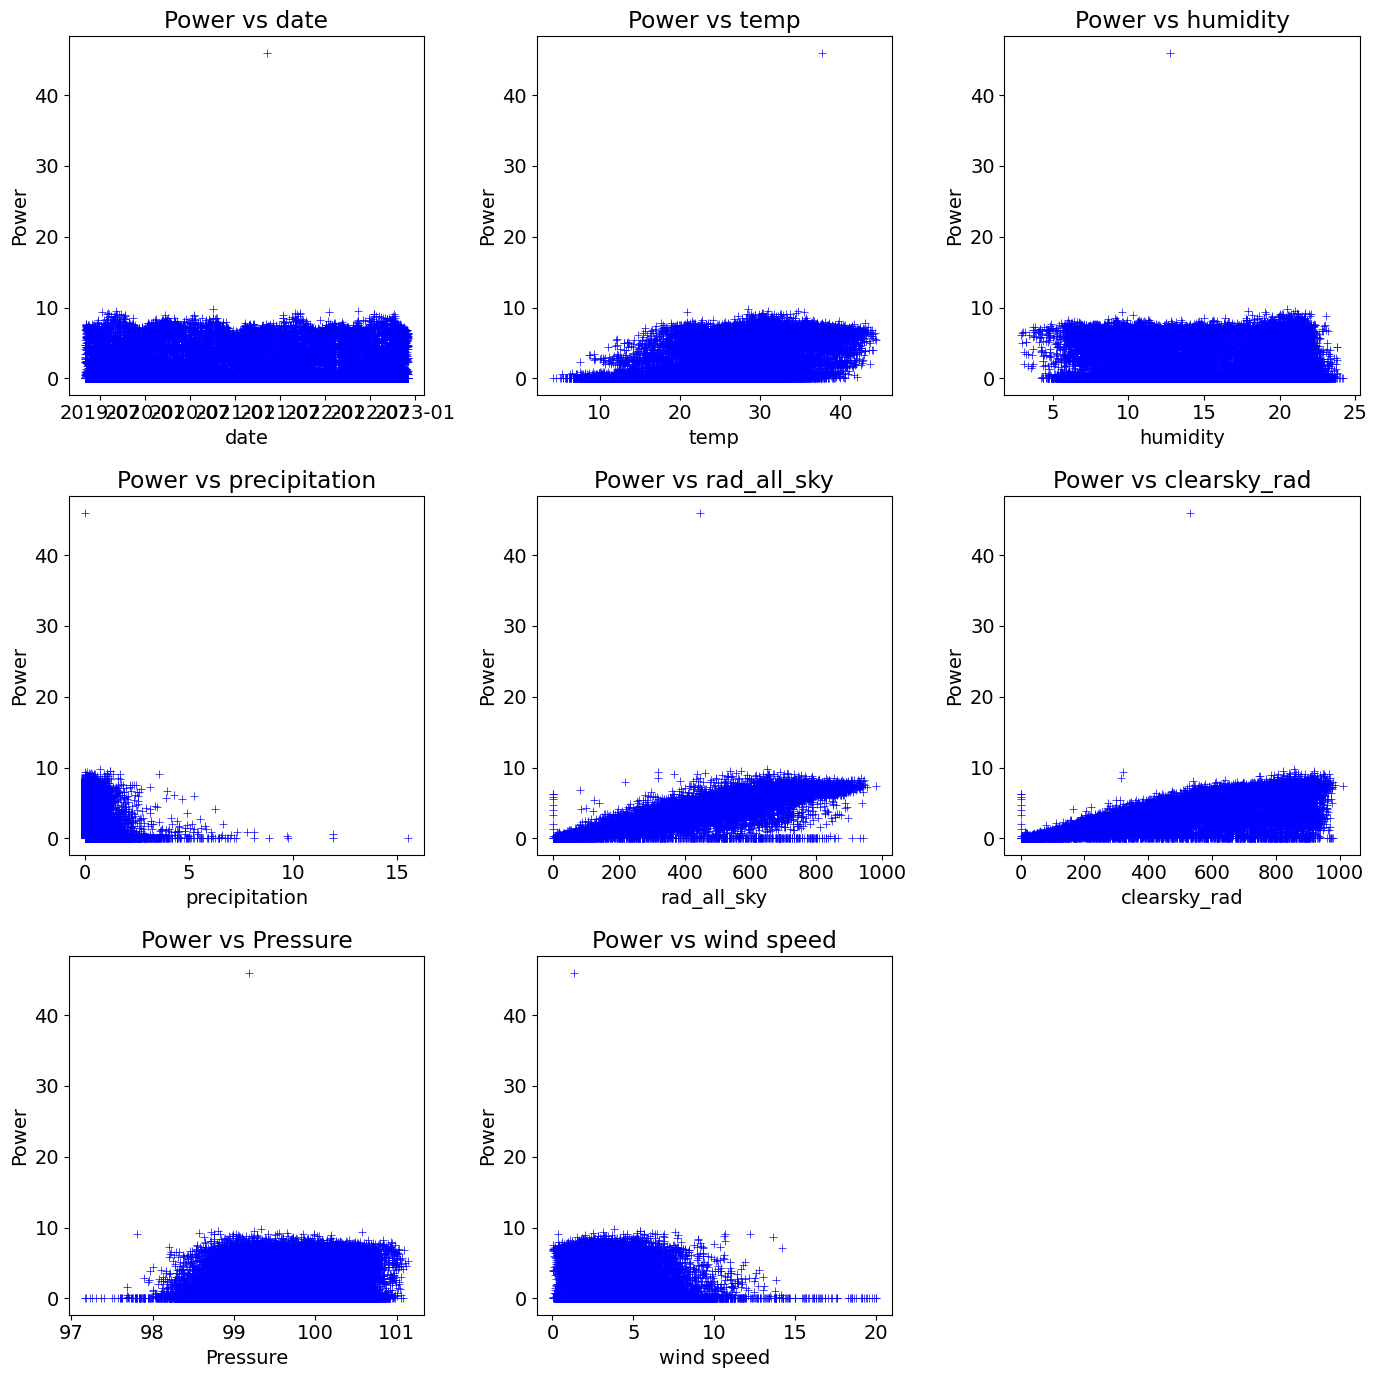

In [ ]:
#scatterplot
plt.rcParams["figure.figsize"] = (14, 14)
plt.rcParams["font.size"] = 14

ylabel = 'Power'
columns = ['date','temp', 'humidity', 'precipitation',	'rad_all_sky',	'clearsky_rad',	'Pressure',	'wind speed']

for index, xlabel in enumerate(columns):
  plt.subplot(3, 3, index+1)
  plt.scatter(df[xlabel], df[ylabel],color='blue',marker='+',linewidth=0.5)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(ylabel + ' vs ' + xlabel)

plt.tight_layout()

In [ ]:

df1 = df[['date','temp','rad_all_sky','clearsky_rad','Power']] #out of all these parameters we are selecting only 4 parameters which are correlated strongly with Power as we need to forecast power eventually
print(df1.shape)

(31440, 5)


In [ ]:
df1

,date,temp,rad_all_sky,clearsky_rad,Power
0,2019-05-02 00:00:00,27.20,0.0,0.0,0.0
1,2019-05-02 01:00:00,26.74,0.0,0.0,0.0
2,2019-05-02 02:00:00,26.51,0.0,0.0,0.0
3,2019-05-02 03:00:00,26.23,0.0,0.0,0.0
4,2019-05-02 04:00:00,26.09,0.0,0.0,0.0
...,...,...,...,...,...
31435,2022-12-01 19:00:00,18.55,0.0,0.0,0.0
31436,2022-12-01 20:00:00,17.77,0.0,0.0,0.0
31437,2022-12-01 21:00:00,17.02,0.0,0.0,0.0
31438,2022-12-01 22:00:00,16.32,0.0,0.0,0.0


In [ ]:
# here we need to remove the date column as it would be added as index for further processing the date format shall not be supported hence we are making /
# it as index
#df1 = df1.drop(['date'], axis=1)


In [ ]:
#creation of training and testing data
#we are taking 80% of the data for training and 20% for testing
train = df1[:int(0.9*(len(data)))]
test = df1[int(0.9*(len(data))):]

In [ ]:
train

,date,temp,rad_all_sky,clearsky_rad,Power
0,2019-05-02 00:00:00,27.20,0.0,0.0,0.0
1,2019-05-02 01:00:00,26.74,0.0,0.0,0.0
2,2019-05-02 02:00:00,26.51,0.0,0.0,0.0
3,2019-05-02 03:00:00,26.23,0.0,0.0,0.0
4,2019-05-02 04:00:00,26.09,0.0,0.0,0.0
...,...,...,...,...,...
28291,2022-07-23 19:00:00,26.98,0.0,0.0,0.0
28292,2022-07-23 20:00:00,26.55,0.0,0.0,0.0
28293,2022-07-23 21:00:00,26.37,0.0,0.0,0.0
28294,2022-07-23 22:00:00,26.27,0.0,0.0,0.0


In [ ]:
test

,date,temp,rad_all_sky,clearsky_rad,Power
28296,2022-07-24 00:00:00,26.21,0.0,0.0,0.0
28297,2022-07-24 01:00:00,26.15,0.0,0.0,0.0
28298,2022-07-24 02:00:00,26.06,0.0,0.0,0.0
28299,2022-07-24 03:00:00,25.95,0.0,0.0,0.0
28300,2022-07-24 04:00:00,25.84,0.0,0.0,0.0
...,...,...,...,...,...
31435,2022-12-01 19:00:00,18.55,0.0,0.0,0.0
31436,2022-12-01 20:00:00,17.77,0.0,0.0,0.0
31437,2022-12-01 21:00:00,17.02,0.0,0.0,0.0
31438,2022-12-01 22:00:00,16.32,0.0,0.0,0.0


In [ ]:
train=train.drop(['date'],axis=1)
test =test.drop(['date'], axis=1)

model = VAR(endog=train)
model_fit = model.fit()


In [ ]:
model = VAR(train.diff()[1:])

In [ ]:
sorted_order=model.select_order(maxlags=20) # we are selecting the order with least AIC and it has happened at 20th order
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        16.32       16.32   1.226e+07       16.32
1        13.41       13.41   6.660e+05       13.41
2        12.80       12.81   3.628e+05       12.81
3        12.73       12.75   3.378e+05       12.73
4        12.61       12.63   2.995e+05       12.62
5        12.51       12.54   2.721e+05       12.52
6        12.47       12.50   2.597e+05       12.48
7        12.43       12.47   2.509e+05       12.44
8        12.40       12.43   2.417e+05       12.41
9        12.36       12.40   2.334e+05       12.37
10       12.31       12.36   2.221e+05       12.33
11       12.24       12.29   2.069e+05       12.26
12       12.11       12.16   1.808e+05       12.12
13       11.97       12.03   1.575e+05       11.99
14       11.82       11.89   1.365e+05       11.85
15       11.75       11.82   1.268e+05       11.77
16       11.62       11.70   1.

In [ ]:
# the minimum lag  is found at lag no 20

In [ ]:
final_trained=VAR(train)
final_result_train=final_trained.fit(20)# since we got minimum lag at step 20 because of that we select 20


In [ ]:
final_result_train.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 18, Aug, 2023
Time:                     04:10:29
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    11.1453
Nobs:                     28276.0    HQIC:                   11.0812
Log likelihood:          -316400.    FPE:                    62994.1
AIC:                      11.0508    Det(Omega_mle):         62277.4
--------------------------------------------------------------------
Results for equation temp
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.003638         0.013415            0.271           0.786
L1.temp                  1.507871         0.005994          251.561           0.000
L1.rad_all_sky           0.000580         0.00007

In [ ]:
var_model = VARMAX(train, order=(10,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

                                          Statespace Model Results                                          
Dep. Variable:     ['temp', 'rad_all_sky', 'clearsky_rad', 'Power']   No. Observations:                28296
Model:                                                      VAR(10)   Log Likelihood             -329377.140
                                                        + intercept   AIC                         659102.279
Date:                                              Fri, 18 Aug 2023   BIC                         660537.862
Time:                                                      04:24:12   HQIC                        659564.188
Sample:                                                           0                                         
                                                            - 28296                                         
Covariance Type:                                                opg                                         
Ljung-Box (L1) (Q):

In [ ]:
#1807
n_forecast = 3144
predict = fitted_model.get_prediction(start=len(train),end=len(train) + n_forecast-1)

data_pred=predict.predicted_mean

In [ ]:
data_pred

,temp,rad_all_sky,clearsky_rad,Power
28296,26.252677,-1.445428,-1.321623,0.102345
28297,26.313465,-0.559745,-3.871911,0.070502
28298,26.257904,-0.681669,-6.808600,0.054889
28299,26.075888,-0.496605,-5.864484,0.008726
28300,26.018281,26.458012,29.369455,0.152674
...,...,...,...,...
31435,25.683251,188.638178,235.758056,1.571187
31436,25.683251,188.638178,235.758056,1.571187
31437,25.683251,188.638178,235.758056,1.571187
31438,25.683251,188.638178,235.758056,1.571187


In [ ]:
data_pred.columns=['temp_predicted','rad_all_sky_predicted','clearsky_rad_predicted','Power_predicted']
data_pred


,temp_predicted,rad_all_sky_predicted,clearsky_rad_predicted,Power_predicted
28296,26.252677,-1.445428,-1.321623,0.102345
28297,26.313465,-0.559745,-3.871911,0.070502
28298,26.257904,-0.681669,-6.808600,0.054889
28299,26.075888,-0.496605,-5.864484,0.008726
28300,26.018281,26.458012,29.369455,0.152674
...,...,...,...,...
31435,25.683251,188.638178,235.758056,1.571187
31436,25.683251,188.638178,235.758056,1.571187
31437,25.683251,188.638178,235.758056,1.571187
31438,25.683251,188.638178,235.758056,1.571187


In [ ]:
from sklearn.metrics import mean_squared_error
import math
from statistics import mean

rmse_Power=math.sqrt(mean_squared_error(data_pred['Power_predicted'],test['Power']))
print('Mean value of Power is : {}. Root Mean Squared Error is :{}'.format(mean(test['Power']),rmse_Power))
rmse_clearsky_rad=math.sqrt(mean_squared_error(data_pred['clearsky_rad_predicted'],test['clearsky_rad']))
print('Mean value of clearsky_rad is : {}. Root Mean Squared Error is :{}'.format(mean(test['clearsky_rad']),rmse_clearsky_rad))
rmse_rad_all_sky=math.sqrt(mean_squared_error(data_pred['rad_all_sky_predicted'],test['rad_all_sky']))
print('Mean value of rad_all_sky is : {}. Root Mean Squared Error is :{}'.format(mean(test['rad_all_sky']),rmse_rad_all_sky))
rmse_temp=math.sqrt(mean_squared_error(data_pred['temp_predicted'],test['temp']))
print('Mean value of temp is : {}. Root Mean Squared Error is :{}'.format(mean(test['temp']),rmse_temp))

Mean value of Power is : 1.619309796437659. Root Mean Squared Error is :2.3911253163836195
Mean value of clearsky_rad is : 243.40377226463104. Root Mean Squared Error is :313.694402236324
Mean value of rad_all_sky is : 185.3054007633588. Root Mean Squared Error is :250.47698563515448
Mean value of temp is : 25.381898854961833. Root Mean Squared Error is :4.354982499977413


In [ ]:
test_vs_pred=pd.concat([data_pred.temp_predicted,test.temp],axis=1)
test_vs_pred.plot(figsize=(12,5))

In [ ]:
test_vs_pred=pd.concat([data_pred.rad_all_sky_predicted,test.rad_all_sky],axis=1)
test_vs_pred.plot(figsize=(12,5))

In [ ]:
test_vs_pred=pd.concat([data_pred.clearsky_rad_predicted,test.clearsky_rad],axis=1)
test_vs_pred.plot(figsize=(12,5))

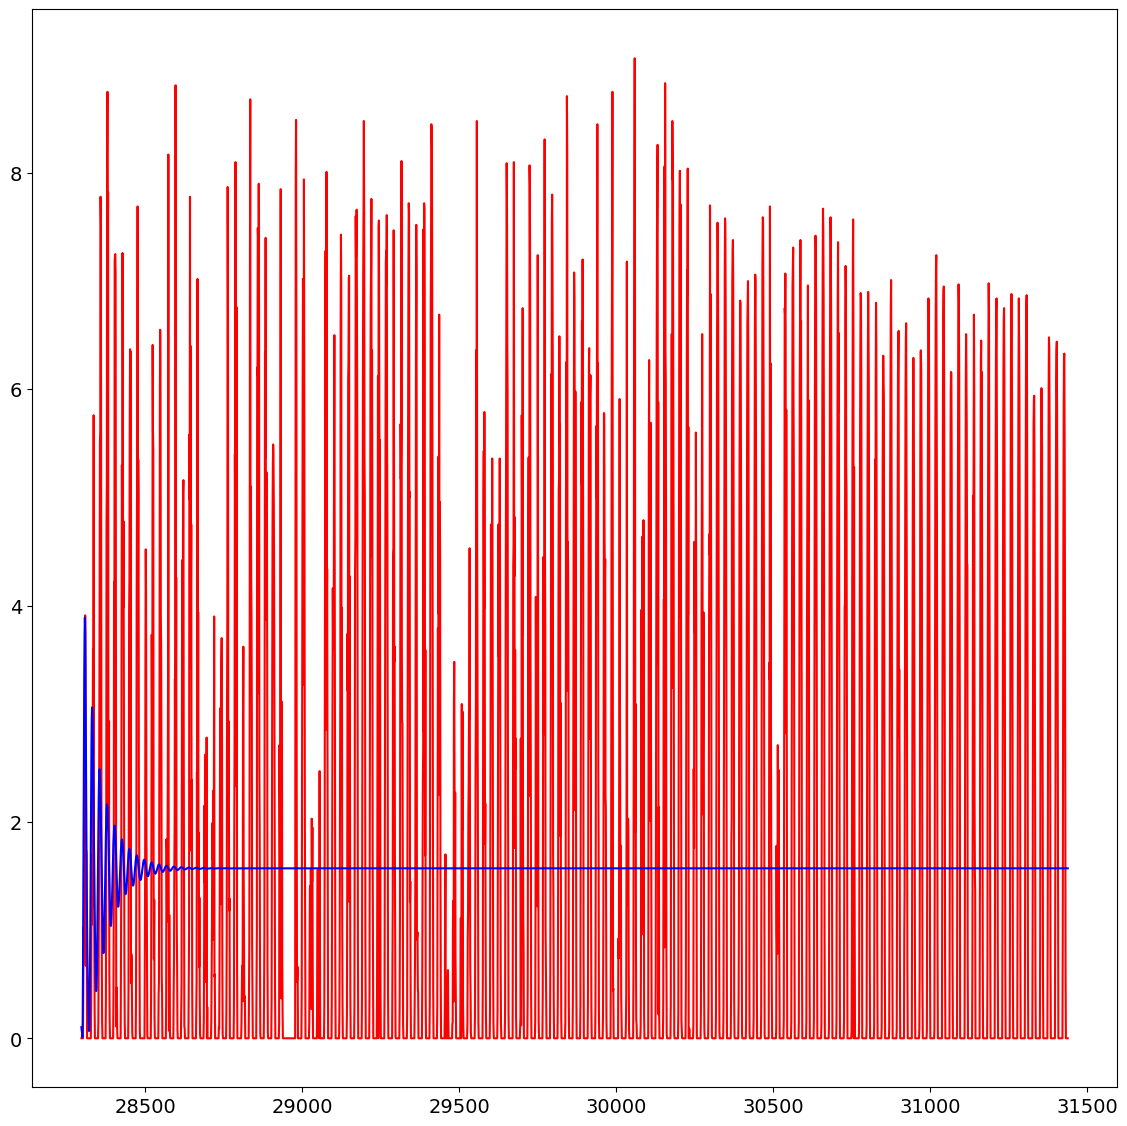

In [ ]:
# now we will plot the actual and predicted vlues so that we can check if  there is any huge variation exists between these two
predicted_actual=pd.concat((test,data_pred),axis=1)
plt.plot(predicted_actual['Power'],label='actual',color='red')
plt.plot(predicted_actual['Power_predicted'],label='predicted',color='blue')

<Axes: >

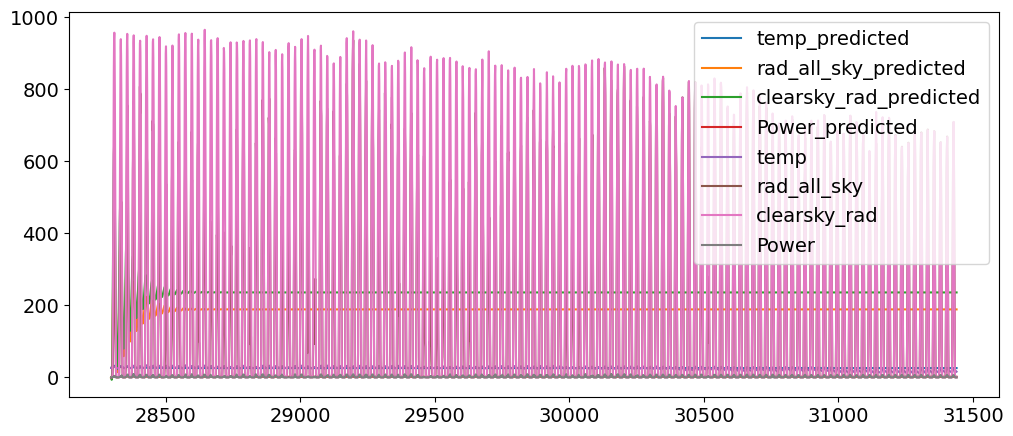

In [ ]:
test_vs_pred=pd.concat([data_pred,test],axis=1)
test_vs_pred.plot(figsize=(12,5))